## HybridSN 高光谱分类
> S. K. Roy, G. Krishna, S. R. Dubey, B. B. Chaudhuri HybridSN: Exploring 3-D–2-D CNN Feature Hierarchy for Hyperspectral Image Classification, IEEE GRSL 2020

本文是基于二维卷积和三维卷积混合使用的高光谱分类任务, 相对较为简单，注意模型网络架构即可

因为这是我读的第一篇高光谱论文，所以简述一下高光谱是什么和如何进行分类任务的把

#### 高光谱是什么 ？

![](https://image.chiullian.cn/img/202410081945865.png)

从左到右分别是单色图像（也就是我们常说的灰度图像，即只含亮度信息，不含色彩信息，该图像的每个像素的 R/G/B 数值都是相同的）、彩色图像、高光谱图像。单从颜色这个角度去看，好像第三张高光谱图像也有颜色（深板岩暗蓝灰色？），实际上这是 False Color，也就是伪彩色图像，实际上严格来说第二张图片有三个通道，而第三张图片则是由上百个通道，我们看到的只是选择了三个通道进行显示所呈现出来的图像，这是我想给大家带来高光谱图像的第一印象。

第二：高光谱图像是由成像光谱仪拍的。而高光谱遥感技术即：利用成像光谱仪，在电磁波的可见光，近红外，中红外和热红外波段范围内，以纳米级光谱仪在几十个或几百个波段同时对地物进行成像，并记录地物的连续光谱响应，实现了地物空间信息，辐射信息，光谱信息的同步获取。

第三：因为物体反射、吸收、透射和辐射电磁波的能力不同，所以我用着成像光谱仪（里面有不同的电磁波）去照地物表面的时候，地物会对这些电磁波有不同的反射，我就可以根据这些反射的不同去区分地表有什么不同的物质。这些反射的信息就是高光谱图像中丰富的光谱信息，在高光谱图像中的第三个维度得以体现，最后就构成了高光谱立体数据。关于立体，看下面这张图就非常清晰了。

![](https://image.chiullian.cn/img/202410081946750.webp)

说白了，高光谱图像和我们平时看到的照片有什么不同呢？空间特征（宽、高）还是一样的，只是你所看到的颜色（在这里或者已经不能说是颜色了），更准确的来说是突破了用颜色代表波段的局限。图像的通道数已经不是普通照片的 3 个，而是几百个，我们所看到的很多高光谱图像数据集，虽然说是数据集，其实每一个数据集就是`一张高光谱图像`，但是里面包含的数据很丰富。

#### 高光谱是怎么分类的 ？
一张图片怎么分类？ 
上面说了一张图片的通道数量非常的多，所携带的信息也就非常的多，而对应一个像素（1 x 1 x 通道数），一个像素所携带的信息也非常的多（非常厚）。我们要做的就是对这个像素进行地物分类，即对每一个像素进行分类。 这个像素属于玉米？土地？树林？，分类取决于你去哪里拍的。




In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
import spectral
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from einops import rearrange, repeat

架构模型图如下：

![](https://image.chiullian.cn/img/202410081854095.png)



In [13]:
from torchinfo import summary

# 地物类别
class_num = 16

class HybridSN(nn.Module):
  def __init__(self):
    super(HybridSN, self).__init__()
    self.conv3d_1 = nn.Sequential(
        nn.Conv3d(1, 8, kernel_size=(7, 3, 3), stride=1, padding=0),
        nn.BatchNorm3d(8),
        nn.ReLU(inplace = True),
    )
    self.conv3d_2 = nn.Sequential(
        nn.Conv3d(8, 16, kernel_size=(5, 3, 3), stride=1, padding=0),
        nn.BatchNorm3d(16),
        nn.ReLU(inplace = True),
    ) 
    self.conv3d_3 = nn.Sequential(
        nn.Conv3d(16, 32, kernel_size=(3, 3, 3), stride=1, padding=0),
        nn.BatchNorm3d(32),
        nn.ReLU(inplace = True)
    )

    self.conv2d_4 = nn.Sequential(
        nn.Conv2d(576, 64, kernel_size=(3, 3), stride=1, padding=0),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace = True),
    )
    self.fc1 = nn.Linear(18496,256)
    self.fc2 = nn.Linear(256,128)
    self.fc3 = nn.Linear(128,class_num)
    self.dropout = nn.Dropout(p = 0.4)

  def forward(self,x):
    out = self.conv3d_1(x)
    out = self.conv3d_2(out)
    out = self.conv3d_3(out)
    out = self.conv2d_4(out.reshape(out.shape[0],-1,19,19))
    out = out.reshape(out.shape[0],-1)
    out = F.relu(self.dropout(self.fc1(out)))
    out = F.relu(self.dropout(self.fc2(out)))
    out = self.fc3(out)
    return out

model = HybridSN()

# 查询参数
total_params = 0
for p in model.parameters():
    total_params += p.numel()
 
model = HybridSN()
print(summary(model, input_size=(1024, 1, 30, 25, 25)))
print(total_params)

Layer (type:depth-idx)                   Output Shape              Param #
HybridSN                                 [1024, 16]                --
├─Sequential: 1-1                        [1024, 8, 24, 23, 23]     --
│    └─Conv3d: 2-1                       [1024, 8, 24, 23, 23]     512
│    └─BatchNorm3d: 2-2                  [1024, 8, 24, 23, 23]     16
│    └─ReLU: 2-3                         [1024, 8, 24, 23, 23]     --
├─Sequential: 1-2                        [1024, 16, 20, 21, 21]    --
│    └─Conv3d: 2-4                       [1024, 16, 20, 21, 21]    5,776
│    └─BatchNorm3d: 2-5                  [1024, 16, 20, 21, 21]    32
│    └─ReLU: 2-6                         [1024, 16, 20, 21, 21]    --
├─Sequential: 1-3                        [1024, 32, 18, 19, 19]    --
│    └─Conv3d: 2-7                       [1024, 32, 18, 19, 19]    13,856
│    └─BatchNorm3d: 2-8                  [1024, 32, 18, 19, 19]    64
│    └─ReLU: 2-9                         [1024, 32, 18, 19, 19]    --
├─Seque

In [53]:
# 对高光谱数据 X 应用 PCA 变换
def applyPCA(X, numComponents):
    newX = rearrange(X, 'h w c -> (h w) c')
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = rearrange(newX, '(h w) c -> h w c', h=X.shape[0])
    return newX

# 对单个像素周围提取 patch 时，边缘像素就无法取了，因此，给这部分像素进行 padding 操作
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2 * margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

# 在每个像素周围提取 patch ，然后创建成符合 keras 处理的格式
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    # 给 X 做 padding
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState, stratify=y)
    return X_train, X_test, y_train, y_test
     

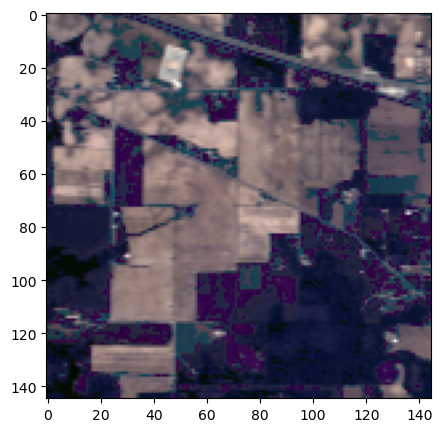

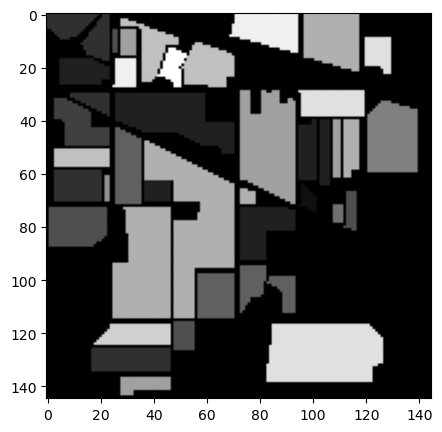

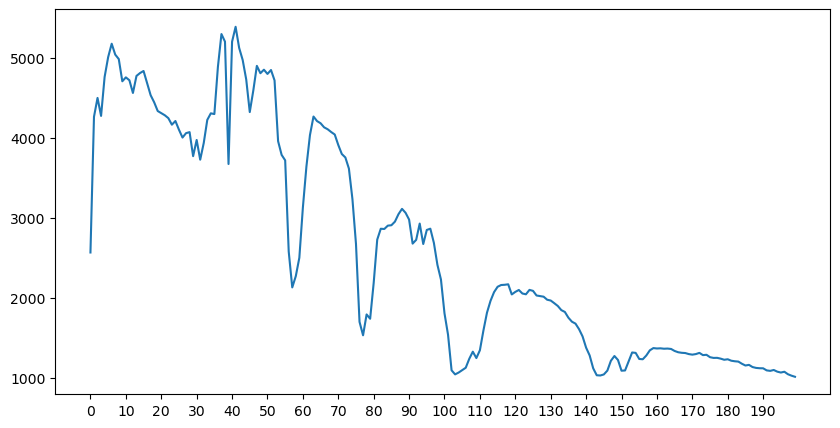

In [111]:
X = sio.loadmat('../dataset/Indian_pines/Indian_pines_corrected.mat')['indian_pines_corrected']
y = sio.loadmat('../dataset/Indian_pines/Indian_pines_gt.mat')['indian_pines_gt']

# 抽三个波段出来显示
spectral.imshow(X, (30, 20, 15), figsize=(5, 5))
spectral.imshow(y, figsize=(5, 5))

plt.figure(figsize=(10, 5))
plt.plot(X[1, 20])
plt.xticks(range(0, 200, 10))

plt.show()
# 用于测试样本的比例
test_ratio = 0.90
# 每个像素周围提取 patch 的尺寸
patch_size = 25
# 使用 PCA 降维，得到主成分的数量
pca_components = 30

In [78]:
print('Hyperspectral data shape: ', X.shape)
print('Label shape: ', y.shape)

print('\n... ... PCA tranformation ... ...')
X_pca = applyPCA(X, numComponents=pca_components)
print('Data shape after PCA: ', X_pca.shape)

print('\n... ... create data cubes ... ...')
X_pca, y = createImageCubes(X_pca, y, windowSize=patch_size)
print('Data cube X shape: ', X_pca.shape)
print('Data cube y shape: ', y.shape)

print('\n... ... create train & test data ... ...')
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X_pca, y, test_ratio)
print('Xtrain shape: ', Xtrain.shape)
print('Xtest  shape: ', Xtest.shape)

# 改变 Xtrain, Ytrain 的形状，以符合 keras 的要求
Xtrain = Xtrain.reshape(-1, patch_size, patch_size, pca_components, 1)
Xtest  = Xtest.reshape(-1, patch_size, patch_size, pca_components, 1)
print('before transpose: Xtrain shape: ', Xtrain.shape) 
print('before transpose: Xtest  shape: ', Xtest.shape) 

# 为了适应 pytorch 结构，数据要做 transpose
Xtrain = Xtrain.transpose(0, 4, 3, 1, 2)
Xtest  = Xtest.transpose(0, 4, 3, 1, 2)
print('after transpose: Xtrain shape: ', Xtrain.shape) 
print('after transpose: Xtest  shape: ', Xtest.shape) 


""" Training dataset"""
class TrainDS(torch.utils.data.Dataset): 
    def __init__(self):
        self.len = Xtrain.shape[0]
        self.x_data = torch.FloatTensor(Xtrain)
        self.y_data = torch.LongTensor(ytrain)        
    def __getitem__(self, index):
        # 根据索引返回数据和对应的标签
        return self.x_data[index], self.y_data[index]
    def __len__(self): 
        # 返回文件数据的数目
        return self.len

""" Testing dataset"""
class TestDS(torch.utils.data.Dataset): 
    def __init__(self):
        self.len = Xtest.shape[0]
        self.x_data = torch.FloatTensor(Xtest)
        self.y_data = torch.LongTensor(ytest)
    def __getitem__(self, index):
        # 根据索引返回数据和对应的标签
        return self.x_data[index], self.y_data[index]
    def __len__(self): 
        # 返回文件数据的数目
        return self.len

# 创建 trainloader 和 testloader
trainset = TrainDS()
testset  = TestDS()
train_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=128, shuffle=True)
test_loader  = torch.utils.data.DataLoader(dataset=testset,  batch_size=128, shuffle=False)


Hyperspectral data shape:  (145, 145, 200)
Label shape:  (145, 145)

... ... PCA tranformation ... ...
Data shape after PCA:  (145, 145, 30)


IndexError: index 145 is out of bounds for axis 2 with size 30

In [56]:
net = HybridSN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)

epochs = 10
total_loss = 0.0

for epoch in range(epochs):
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print('[Epoch: %d]   [loss avg: %.4f]   [current loss: %.4f]' %(epoch + 1, total_loss/(epoch+1), loss.item()))


[Epoch: 1]   [loss avg: 19.3708]   [current loss: 1.9856]
[Epoch: 2]   [loss avg: 15.6779]   [current loss: 1.3176]
[Epoch: 3]   [loss avg: 12.9311]   [current loss: 0.7690]
[Epoch: 4]   [loss avg: 10.9602]   [current loss: 0.5904]
[Epoch: 5]   [loss avg: 9.5062]   [current loss: 0.4274]
[Epoch: 6]   [loss avg: 8.3905]   [current loss: 0.2900]
[Epoch: 7]   [loss avg: 7.4749]   [current loss: 0.1784]
[Epoch: 8]   [loss avg: 6.7445]   [current loss: 0.2373]
[Epoch: 9]   [loss avg: 6.1187]   [current loss: 0.0771]
[Epoch: 10]   [loss avg: 5.5760]   [current loss: 0.0664]


In [57]:
# 预测
count = 0
# 模型测试
for inputs, _ in test_loader:
    inputs = inputs.to(device)
    outputs = net(inputs)
    
    outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
    if count == 0:
        y_pred_test =  outputs
        count = 1
    else:
        y_pred_test = np.concatenate( (y_pred_test, outputs) )

# 生成分类报告
classification = classification_report(ytest, y_pred_test, digits=4)
print(classification)

              precision    recall  f1-score   support

         0.0     0.9643    0.6585    0.7826        41
         1.0     0.9420    0.9346    0.9383      1285
         2.0     0.9507    0.9558    0.9533       747
         3.0     0.9412    0.9014    0.9209       213
         4.0     0.9192    0.9678    0.9429       435
         5.0     0.9430    0.9817    0.9620       657
         6.0     1.0000    0.3200    0.4848        25
         7.0     0.9837    0.9814    0.9825       430
         8.0     1.0000    0.0556    0.1053        18
         9.0     0.9578    0.9349    0.9462       875
        10.0     0.9631    0.9796    0.9713      2210
        11.0     0.9020    0.9307    0.9161       534
        12.0     0.8937    1.0000    0.9439       185
        13.0     0.9748    0.9860    0.9804      1139
        14.0     0.9788    0.9308    0.9542       347
        15.0     0.8667    0.4643    0.6047        84

    accuracy                         0.9519      9225
   macro avg     0.9488   

In [58]:
# 逐像素预测类别
X = sio.loadmat('../dataset/Indian_pines/Indian_pines_corrected.mat')['indian_pines_corrected']
y = sio.loadmat('../dataset/Indian_pines/Indian_pines_gt.mat')['indian_pines_gt']

height = y.shape[0]
width = y.shape[1]

X = applyPCA(X, numComponents= pca_components)
X = padWithZeros(X, patch_size//2)

# 逐像素预测类别
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        if int(y[i,j]) == 0:
            continue
        else :
            image_patch = X[i:i+patch_size, j:j+patch_size, :]
            image_patch = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1)
            X_test_image = torch.FloatTensor(image_patch.transpose(0, 4, 3, 1, 2)).to(device)                                   
            prediction = net(X_test_image)
            prediction = np.argmax(prediction.detach().cpu().numpy(), axis=1)
            outputs[i][j] = prediction+1
    if i % 20 == 0:
        print('... ... row ', i, ' handling ... ...')

... ... row  0  handling ... ...


C:\Users\chiullian\AppData\Local\Temp\ipykernel_14480\1331313366.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  outputs[i][j] = prediction+1


... ... row  20  handling ... ...
... ... row  40  handling ... ...
... ... row  60  handling ... ...
... ... row  80  handling ... ...
... ... row  100  handling ... ...
... ... row  120  handling ... ...
... ... row  140  handling ... ...


D:\Anaconda\envs\pytorch\Lib\site-packages\spectral\graphics\spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


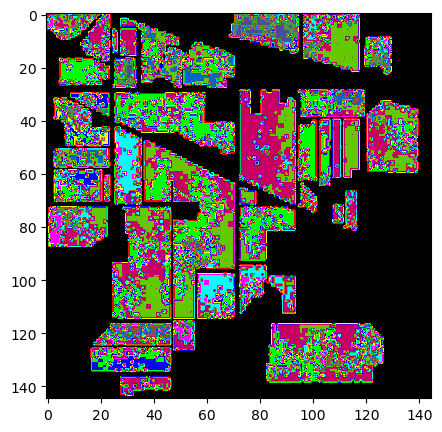

In [59]:

predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(5,5))